<a href="https://colab.research.google.com/github/zaccowan/MLA_ZSC/blob/main/Classification_In_class_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Prediction: Model Selection and Hyperparameter Tuning

In this notebook, you will:
1. Load the Titanic dataset from an online source.
2. Perform basic EDA to understand the data.
3. Use pipelines to preprocess numerical and categorical data.
4. Train and evaluate multiple classification models (KNN, SVC, Random Forest, Decision Tree, Logistic Regression, Bagging, and Boosting).
5. Conduct hyperparameter tuning to find the best model.
6. Write reflection on the findings

---

## 1. Importing Libraries
**Task**: Import the necessary libraries for data handling, visualization, model training, and evaluation.

In [1]:
# import libraries for data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries for model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## 2. Load the titanic dataset from seaborn

In [2]:
titanic = sns.load_dataset('titanic')

## 3. Basic EDA (Exploratory Data Analysis)
Question 1: What is the shape of the dataset?

In [3]:
print("Shape: " , titanic.shape)

Shape:  (891, 15)


Question 2: Are there any missing values?


In [4]:
titanic.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


Question 3: Visualize some relationships (atleast 3). such as:

- The distribution of numerical features like age and fare.
- The survival rate by different classes, gender, etc.

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [6]:
titanic.describe().drop('count')

,survived,pclass,age,sibsp,parch,fare
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


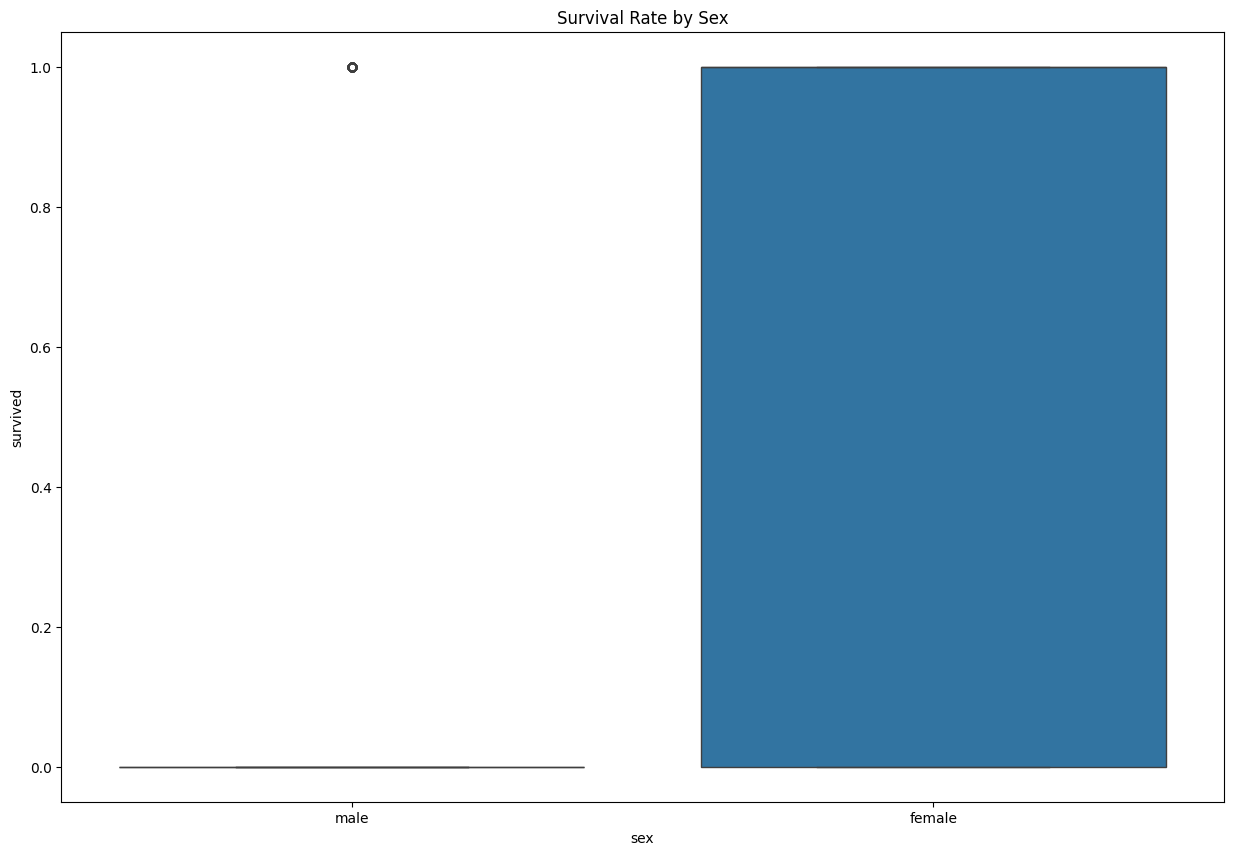

In [7]:
plt.figure(figsize=(15,10))
sns.boxplot(x = 'sex', y = 'survived', data = titanic)
plt.title('Survival Rate by Sex')
plt.show()

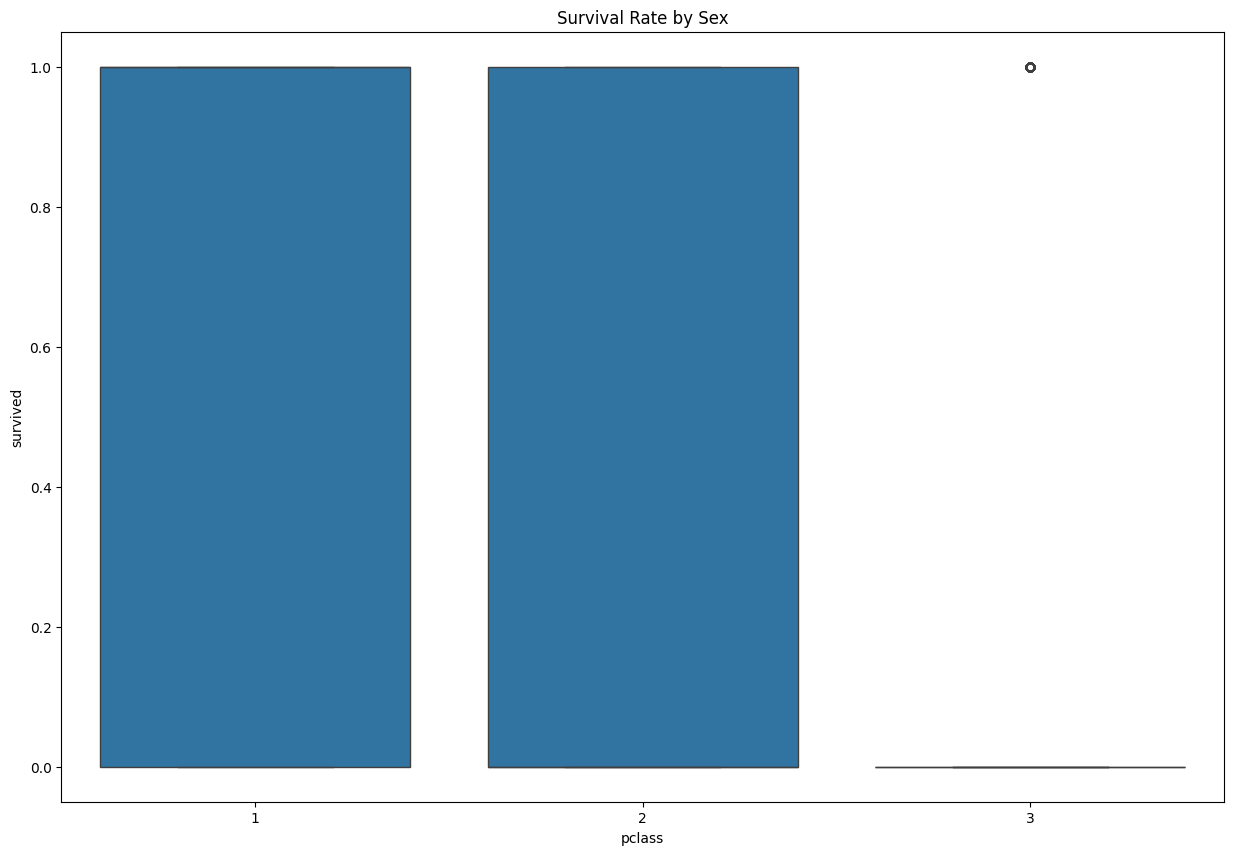

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(x = 'pclass', y = 'survived', data = titanic)
plt.title('Survival Rate by Sex')
plt.show()

<Figure size 1500x1000 with 0 Axes>

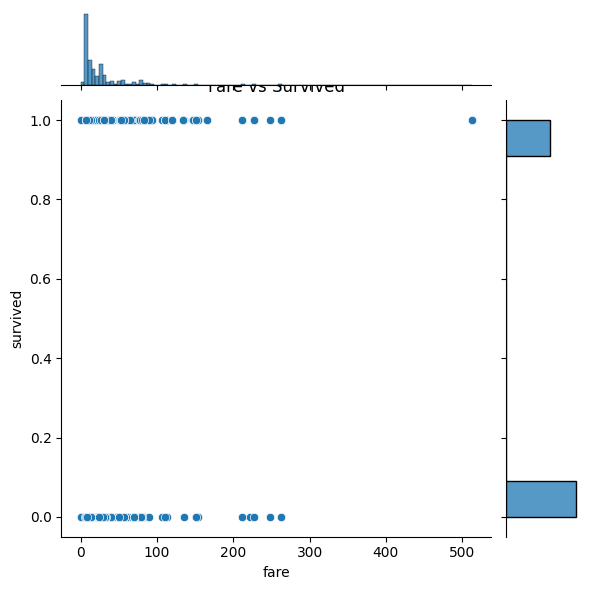

In [9]:
plt.figure(figsize=(15,10))
sns.jointplot(x = 'fare', y = 'survived', data = titanic)
plt.title('Fare vs Survived')
plt.show()

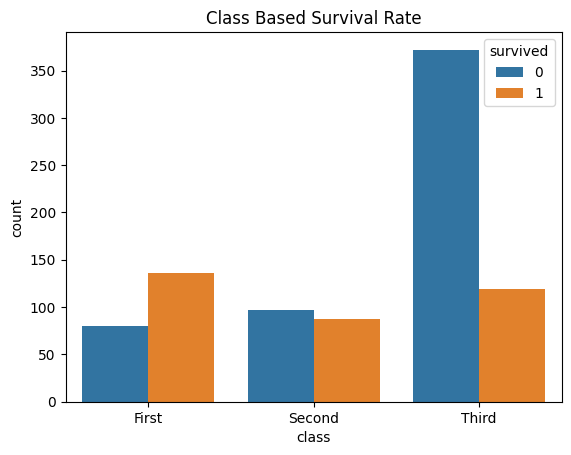

In [10]:
sns.countplot(x="class", hue = 'survived', data = titanic)
plt.title('Class Based Survival Rate')
plt.show()

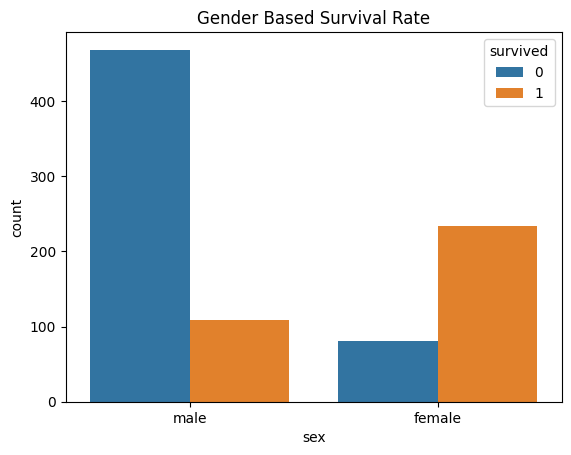

In [11]:
sns.countplot(x="sex", hue = 'survived', data = titanic)
plt.title('Gender Based Survival Rate')
plt.show()

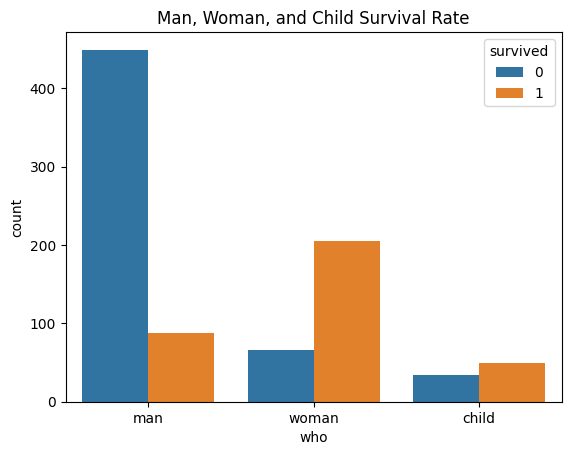

In [12]:
sns.countplot(x="who", hue = 'survived', data = titanic)
plt.title('Man, Woman, and Child Survival Rate')
plt.show()

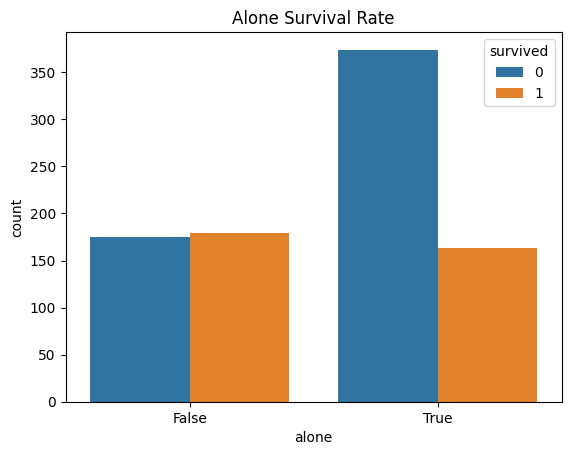

In [13]:
sns.countplot(x="alone", hue = 'survived', data = titanic)
plt.title('Alone Survival Rate')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

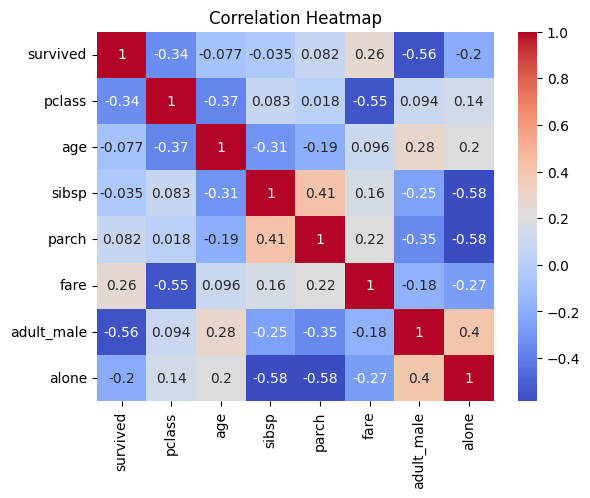

In [14]:
sns.heatmap(titanic.select_dtypes(["number", "bool"]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [15]:
# Split the data into features and target
x = titanic[['age', 'fare', 'pclass', 'sex', 'embarked', 'who', 'alone']]
y = titanic['survived']

# EDA Observations

## Count Plots
- Class Based Survival Rate
  - People in first class survived at higher rates
- Sex Based Survival Rate
  - Females survived at higher rates



### Split the data into training and testing sets

In [16]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 4. Data Preprocessing with Pipelines
Task: Create a data preprocessing pipeline for numerical and categorical features.

- Numerical features: Use StandardScaler to scale them.
- Categorical features: Use OneHotEncoder to encode them.
- impute missing values

In [28]:
num_cols = x.select_dtypes(["number"]).columns
cat_cols = x.select_dtypes(['object', "bool"]).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_transformer, num_cols),
    ('categorical', categorical_features, cat_cols)
])

## Training data with multiple models

In [29]:
# Define models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Bagging Classifier': BaggingClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}



# Evaluate each model
for model_name, model in models.items():
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Train the model
    pipeline.fit(x_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(x_test)

    # Print accuracy and classification report
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))




Model: K-Nearest Neighbors
Accuracy: 0.8156424581005587

Model: Logistic Regression
Accuracy: 0.8100558659217877

Model: Decision Tree
Accuracy: 0.7821229050279329

Model: Random Forest
Accuracy: 0.8212290502793296

Model: Support Vector Machine
Accuracy: 0.8044692737430168

Model: Bagging Classifier
Accuracy: 0.8044692737430168

Model: Gradient Boosting
Accuracy: 0.8379888268156425


#Hyperparameter Tuning
## Define parameter grids for the top 2 models
Example:
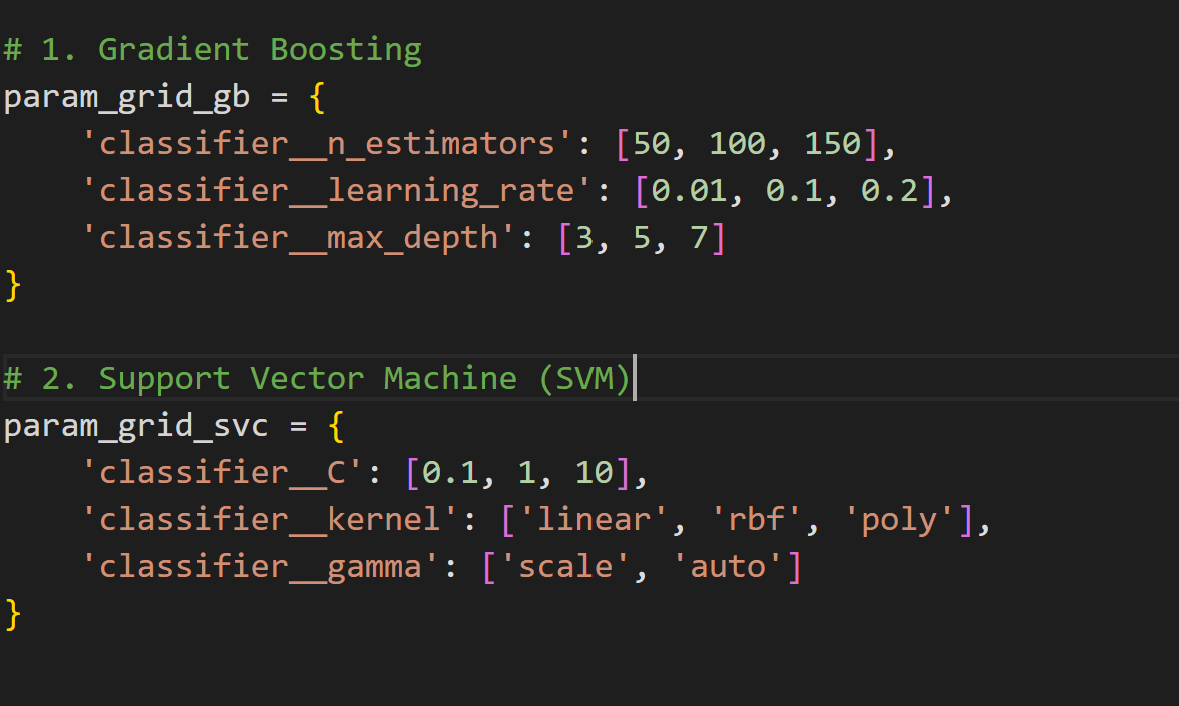

In [30]:
# 1. Gradient Boosting
param_grid_gb = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
}

# 2. Support Vector Machine (SVM)
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
}



## List of models and their corresponding parameter grids
Example
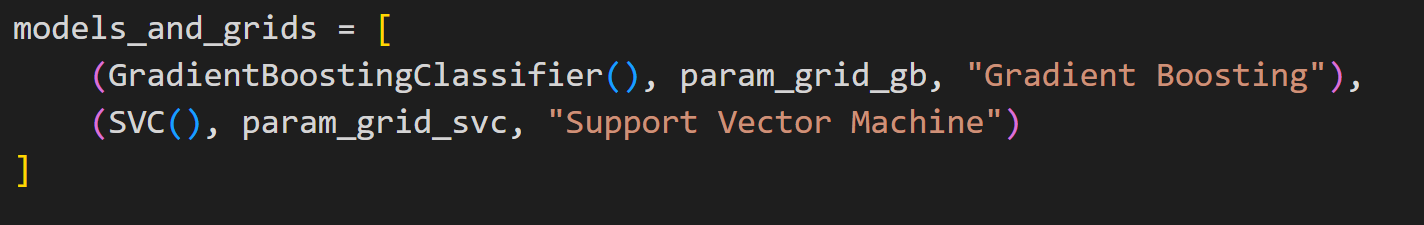

In [31]:
models_and_grids = [
    (GradientBoostingClassifier(), param_grid_gb, "Gradient Boosting"),
    (SVC(), param_grid_svc, "Support Vector Machine")
]

In [32]:
from sklearn.model_selection import GridSearchCV

# Loop through each model and perform GridSearchCV
for model, param_grid, model_name in models_and_grids:
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model
    grid_search.fit(x_train, y_train)

    # Output the best parameters and best cross-validation score for each model
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")


Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 150}
Best cross-validation accuracy for Gradient Boosting: 0.8258

Best parameters for Support Vector Machine: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best cross-validation accuracy for Support Vector Machine: 0.8272


## 7.Reflection and Analysis
Which model performed the best without tuning?

1. Based on the initial accuracy scores, which model had the highest accuracy before hyperparameter tuning?

2. What are two best top performing model? How did hyperparameter tuning affect the top-performing models?

3. Compare the accuracy scores before and after tuning for each of the top-performing models. Which model showed the most improvement?

4. Summarize the optimal parameters found during hyperparameter tuning. How do these optimal parameters differ from the default ones?

5. Did any model experience overfitting after tuning?
Examine the training versus test accuracy for each of the top models after tuning.
Based on your findings, which model would you select for deployment, and why?

6. Considering both performance (accuracy) and other factors like model complexity and interpretability, which model would you choose as the best candidate for deployment? Explain your reasoning.